In [18]:
!python -m pip uninstall torch

^C


In [12]:
!python -m pip install --upgrade pip

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ------------------- -------------------- 1.0/2.1 MB 21.8 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 22.2 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [8]:
# !python -m pip install numml
# !python -m pip install pyamg
!python -m pip install matplotlib

     ---------------------------------------- 0.0/160.4 kB ? eta -:--:--
     -------------------------------------- 160.4/160.4 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   -------- ------------------------------- 1.6/7.6 MB 32.9 MB/s eta 0:00:01
   -------------- ------------------------- 2.7/7.6 MB 28.5 MB/s eta 0:00:01
   -------------------- ------------------- 3.8/7.6 MB 27.2 MB/s eta 0:00:01
   -------------------------- ------------- 5.0/7.6 MB 26.7 MB/s eta 0:00:01
   -------------------------------- ------- 6.2/7.6 MB 26.4 MB/s eta 0:00:01
   -------------------------------------- - 7.4/7.6 MB 26.1 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 25.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/181.9 kB ? eta -:--:--
   ---------------------------------------- 181.9/181.9 kB ? eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------- -

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [19]:
# !python -m pip install torch
!python -m pip install torch torchvision torchaudio


In [21]:
import torch
print(torch.__config__.show())

PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=C:/actions-runner/_work/pytorch/pytorch/builder/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /bigobj /FS -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_FBGEMM -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE /utf-8 /wd4624 /wd4068 /wd4067 /wd4267 /wd4661 /wd4717 /wd4244 /wd4804 /wd4273, LAPACK_INFO=mkl, PERF_WITH_AVX=1, PERF_WITH_AVX2=1, PERF_WITH_AVX512=1, TORCH_DISABLE_GPU_ASSERTS=OFF, TORCH_VERSION=2.1.2, USE_CUDA=0, USE_CUDNN=OFF, USE_EXCEPTION_PTR=1, USE_GFLAGS=OFF, USE_GLOG=OFF, USE_MKL=ON, USE_MKLDN

Running with preconditioner ilu
Iterative solver with preconditioner
problem3.txt
Size of A: (213, 474)
primal error: 0.0
dual error: 724.7461624596573
eta_k: 1
total error: 724.7461624596573
Preconditioner calculation time: 7.000001005508238e-07
Time to solve with preconditioner ilu: 0.0020003318786621094
1
primal error: 1.9281902840971213e-09
dual error: 714.7765247468288
eta_k: 0.09134882217248907
total error: 714.7765247468288
Preconditioner calculation time: 1.0000001111620804e-06
Time to solve with preconditioner ilu: 0.002000093460083008
2
primal error: 6.870470151311368e-09
dual error: 701.1399249108102
eta_k: 0.08133947270956247
total error: 701.1399249108102
Preconditioner calculation time: 7.000001005508238e-07
Time to solve with preconditioner ilu: 0.0019998550415039062
3
primal error: 6.69160959880525e-09
dual error: 679.5547601223562
eta_k: 0.07135360823628834
total error: 679.5547601223562
Preconditioner calculation time: 6.000000212225132e-07
Time to solve with precondi

C:\Users\jonat\AppData\Local\Temp\ipykernel_24824\2803180737.py:535: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  solution, info = spla.lgmres(A, b, x0 = x0, M=M_inv, tol=tol)


Time to solve with preconditioner ilu: 0.004000663757324219
11
primal error: 3.438696083287468e-11
dual error: 0.006712204414054631
eta_k: 6.642128133732529e-06
total error: 0.006712204414054631
Preconditioner calculation time: 3.999998625658918e-07
Time to solve with preconditioner ilu: 0.00400090217590332
12
primal error: 1.7695346434367967e-09
dual error: 0.0009627736496516113
eta_k: 1.4705420799548992e-06
total error: 0.0009627736496532374
Preconditioner calculation time: 7.999999525054591e-07
Time to solve with preconditioner ilu: 0.004000663757324219
13
primal error: 7.713961533090906e-10
dual error: 0.0002292230799170938
eta_k: 4.500890500755201e-07
total error: 0.00022922307991839178
Preconditioner calculation time: 6.000000212225132e-07
Time to solve with preconditioner ilu: 0.004000186920166016
14
primal error: 1.2863546336218953e-09
dual error: 3.7862956005778357e-05
eta_k: 1.0845463062230017e-07
total error: 3.786295602762964e-05
Preconditioner calculation time: 7.999999525

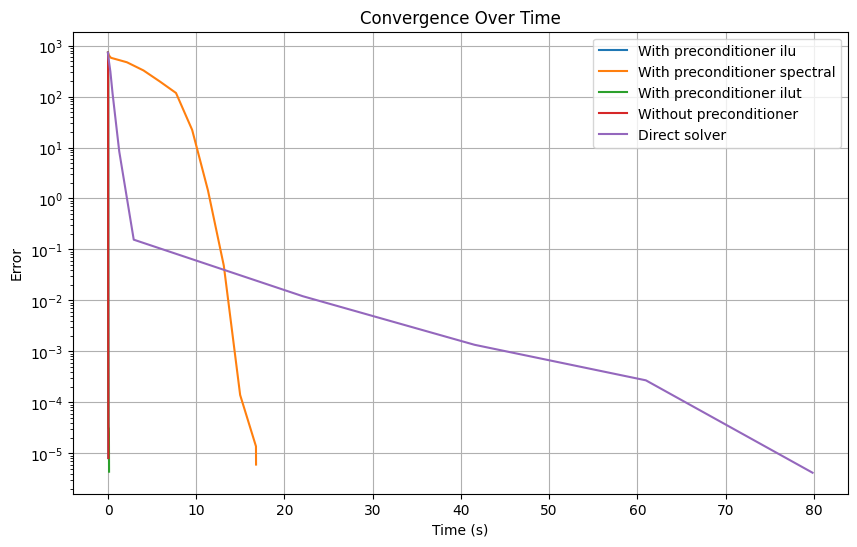

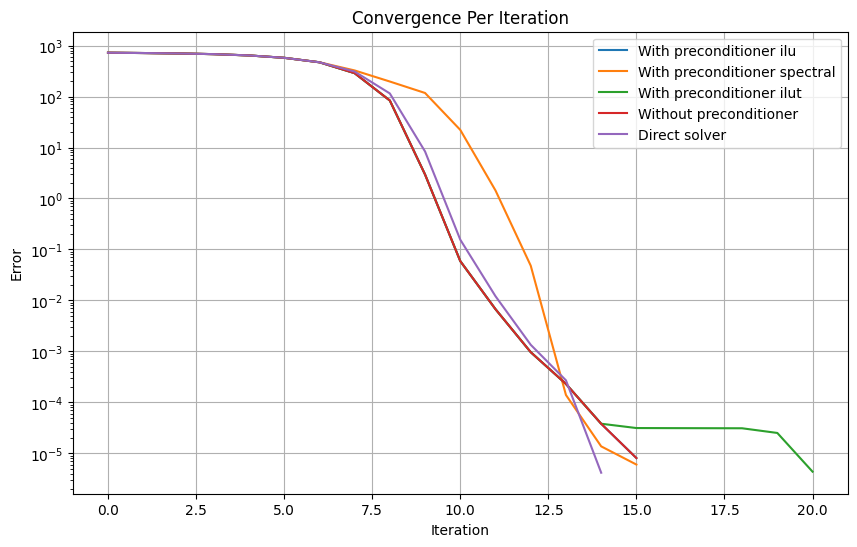

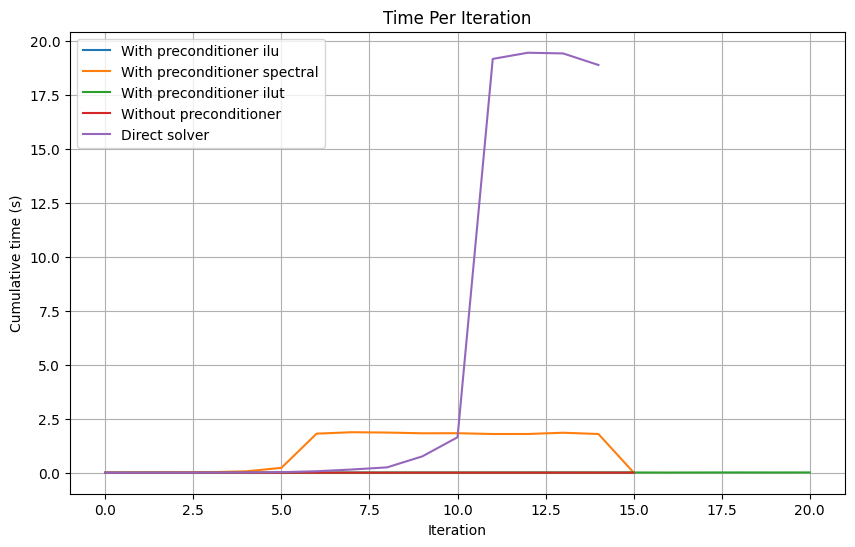

In [7]:
import re
import numpy as np
# import numml as nl
# import ilupp
import torch
import networkx as nx
import pynetgen # see: https://pypi.org/project/pynetgen/
import cvxpy as cvx
import scipy.sparse as sp
# from scipy.sparse.linalg import scale
from scipy.sparse.csgraph import reverse_cuthill_mckee
import scipy.sparse.linalg as spla

import pyamg
import matplotlib.pyplot as plt

import random
import time


from learning_preconditioners_main.krylov.cg import stopping_criterion, fb_solve, fb_solve_joint, conjugate_gradient, preconditioned_conjugate_gradient
from learning_preconditioners_main.krylov.preconditioner import jacobi_preconditioner

torch.set_default_dtype(torch.float64)

# Max flow problem
def parse_dimacs(filename):
    with open(filename, 'r') as f:
        for l in f:
            x, *y = l.split()

            if x.startswith('p'):
                # problem, nodes, edges
                m, n = re.findall('\d+', l)
                # m number of nodes (r = regular)
                nodes = ["r" for i in range(int(m))]
                # n number of edges
                edges = []

            elif x.startswith('n'):
                _, m , n = l.split()
                # set node to target / sink
                nodes[int(m)-1] = n

            elif x.startswith('a'):
                # start, end, capacity
                s, e, c = re.findall('\d+', l )
                edges.append([int(s)-1, int(e)-1, int(c)])

    # create graph
    g = nx.DiGraph()
    # add nodes
    for i in range(len(nodes)):
        g.add_node(i, name=nodes[i])
    # add edges
    for i, e in enumerate(edges):
        g.add_edge(e[0], e[1], capacity=e[2], idx=i)
    # return the graph
    return g


def generate_graph(seed,fname="problem.txt", num_nodes=50, num_edges=200, num_sinks=1, num_sources=1):
    
    # maxcost = mincost = 1 forces max cut problem
    # rng = 1 uses the random number generator from python

    rng = np.random.RandomState(seed)

    pynetgen.netgen_generate(seed=seed, nodes=num_nodes, density=num_edges, sinks=num_sinks, sources=num_sources,
                             rng=1, maxcost=1, mincost=1, supply=100, mincap=1, maxcap=100, fname=fname)
    return 0


def graph_to_lp(g:nx.DiGraph):
    # TODO: convert the graph to a linear program
    # RETURNS: (A, b, c)
    E = g.number_of_edges()
    V = g.number_of_nodes()
    S = 0
    T = 0
    sink_set = set()
    for node,data in g.nodes(data=True):
        edge_list = list(g.edges(node,data=True))
        if data['name'] == "s" :
            S += 1
        elif data['name'] == 't':
            T += 1
            sink_set.add(node)
    # print(S,T)
    length_of_y = E+V-S-T #this is the number of yv and y uv

    #length of x of the orignal form is the yv + yuv
    #for the normal form, each free variable should be substitude by two variables minus like a - b
    # while all y_uv are non negative and all y_v are free, the length should be length of y + V-S-T
    # then we should add all relax variable for these so the final should be
    #length_of_y + V-S-T +E = length_of_y *2
    c = np.zeros(length_of_y*2)

    #it has E constraints , and the # of variables are 2*length_of_y ,
    # so the shape of A should be
    #[E,length_of_y*2]

    A = np.zeros((E,length_of_y*2))
    x = np.ones(length_of_y*2)
    y = np.zeros(E)
    #length of b should be the number of the inequalities constraints
    b = np.zeros(E)
    for node, data in g.nodes(data=True):
        # print(node)

        edge_list = list(g.edges(node,data=True))
        # print(edge_list)
        for e in edge_list:
            #We want to minimize sum(c(u,v)*y_uv), we can assume the first E variables are y_uv
            #So for each edge we should change the corresponding c to the capacity of this edge
            c[e[-1]['idx']] = e[-1]['capacity']

            #for each yuv
            A[e[-1]['idx']][e[-1]['idx']] = 1

            #relax variable, we put the relax variables after all yuv and yv
            A[e[-1]['idx']][e[-1]['idx']+2*length_of_y-E]=-1


            if data['name'] == 's':
                #since yv are free, we should subsitute it with a-b, so the coefficient of the yv_a,yv_b is 1,-1
                A[e[-1]['idx']][E+2*(e[1]-S)] = 1
                A[e[-1]['idx']][E+2*(e[1]-S)+1] = -1
                #when the edge is from the source, we can set the corresponding initial x to 1
                x[e[-1]['idx']] = 2
                #only the edge from 's' we need to change it to 1
                b[e[-1]['idx']] = 1
                y[e[-1]['idx']] = 1
            elif e[1] in sink_set :
                A[e[-1]['idx']][E+2*(e[0]-S)] = -1
                A[e[-1]['idx']][E+2*(e[0]-S)+1] = 1
                y[e[-1]['idx']] = 1
            else:
                A[e[-1]['idx']][E+2*(e[1]-S)] = 1
                A[e[-1]['idx']][E+2*(e[1]-S)+1] = -1
                A[e[-1]['idx']][E+2*(e[0]-S)] = -1
                A[e[-1]['idx']][E+2*(e[0]-S)+1] = 1
                y[e[-1]['idx']] = 1
        # after this step, each row illustrate the



        # you can check if a node is a source or sink by checking the name
        # data['name'] == 's' or data['name'] == 't'

        # get the edges of the node
        # g.edges(node, data=True)
    return A, b, c, x, y

def is_symmetric(matrix):
    """
    Check if a given matrix is symmetric.

    Parameters:
    matrix (np.ndarray): A numpy array representing the matrix.

    Returns:
    bool: True if the matrix is symmetric, False otherwise.
    """
    # First, ensure the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False

    # Check if matrix is equal to its transpose
    return np.allclose(matrix, matrix.T)

def is_positive_definite(matrix):
    """
    Check if the matrix is positive definite.
    """
    # Ensure the matrix is symmetric
    if not is_symmetric(matrix):
        return False

    # Calculate eigenvalues
    eigenvalues = np.linalg.eigvalsh(matrix)

    # Check if all eigenvalues are positive
    return np.all(eigenvalues > 0)

def quantify_differences(a, b):
    # Convert PyTorch tensor to a NumPy array if necessary
    if torch.is_tensor(b):
        b = b.cpu().numpy()
    if torch.is_tensor(a):
        a = a.cpu().numpy()

    print("Quality checks a:")
    # Count NaN values
    num_nan = np.sum(np.isnan(a))

    # Count infinite values
    num_inf = np.sum(np.isinf(a))
    print(f"a: Length: {len(a)} and Number of inf: {num_inf} and number of NaN: {num_nan}")
    
    # print("Quality checks b:")
    # # Count NaN values
    # num_nan = np.sum(np.isnan(b))

    # # Count infinite values
    # num_inf = np.sum(np.isinf(b))
    # print(f"b: Length: {len(b)} and Number of inf: {num_inf} and number of NaN: {num_nan}")
    
    # Now both a and b are NumPy arrays and can be subtracted
    absolute_difference = np.abs(a - b)
    sum_absolute_difference = np.sum(absolute_difference)
    mean_absolute_difference = np.mean(absolute_difference)
    mse = np.mean((a - b) ** 2)
    rmse = np.sqrt(mse)
    max_difference = np.max(absolute_difference)
    euclidean_distance = np.linalg.norm(a - b)

    return {
        "Sum of Absolute Differences": sum_absolute_difference,
        "Mean Absolute Difference": mean_absolute_difference,
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Maximum Difference": max_difference,
        "Euclidean Distance": euclidean_distance
    }

def check_small_values(diagonal, threshold=1e-10):
    is_small = np.abs(diagonal) < threshold
    if np.any(is_small):
        print("Matrix contains very small values on the diagonal.")
        return True
    return False

def adjust_small_values(diagonal, threshold=1e-10):
    # Create a copy of the diagonal to modify
    diagonal_copy = np.copy(diagonal)

    too_small = np.abs(diagonal_copy) < threshold
    diagonal_copy[too_small] = threshold
    return diagonal_copy

def create_perturbation(x, s, mu, iteration, scaling_factor=0.1):
    """
    Creates a perturbation term for the primal-dual algorithm.

    Parameters:
    x (np.array): The current primal variable.
    s (np.array): The current slack variable.
    mu (float): The current estimate of the duality gap.
    iteration (int): The current iteration step.
    scaling_factor (float): A scaling factor for the perturbation.

    Returns:
    np.array: The perturbation term.
    """
    n = len(x)
    e = np.ones(n)

    # Basic perturbation based on the current duality gap and iteration
    basic_perturbation = mu * e * np.exp(-iteration * scaling_factor)

    # Additional scaling based on the norms of x and s
    scale_x = np.linalg.norm(x)
    scale_s = np.linalg.norm(s)
    scaled_perturbation = basic_perturbation * (scale_x + scale_s) / 2

    return scaled_perturbation

def test_feasibility_x(x, A, b, tolerance=1e-6):
    # Test if all elements of x are greater than 0
    all_positive = np.all(x > 0)

    # Test if Ax is approximately equal to b
    Ax = A.dot(x)
    satisfies_Ax_equals_b = np.allclose(Ax, b, atol=tolerance)

    return all_positive, satisfies_Ax_equals_b

def test_feasibility_s(s, lam, A, c, tolerance=1e-6):
    # Check if all elements of s are strictly greater than 0
    all_strictly_positive = np.all(s > 0)

    # Check if s = c - A^T lam
    satisfies_constraint = np.allclose(s, c - A.T @ lam, atol=tolerance)

    return all_strictly_positive, satisfies_constraint

def Alpha(s,x,alpha,delta_s,delta_x):
    alpha_x=[]
    alpha_s=[]
    for i in range(x.shape[0]):
        if delta_x[i]<0:
            alpha_x.append(x.flatten()[i]/-delta_x[i])
        if delta_s[i]<0:
            alpha_s.append(s[i]/-delta_s[i])
    if len(alpha_x)==0 and len(alpha_s)==0:
        return alpha
    else:
        alpha_x.append(np.inf)
        alpha_s.append(np.inf)
        alpha_max = min(min(alpha_x), min(alpha_s))
        alpha_k = min(1,0.99*alpha_max)
    return alpha_k

def not_terminate(x, lam, s, A, b, c, mu, k, max_iterations = 300, tolerance=1e-5):
    # Primal feasibility error: ||Ax - b||
    primal_feasibility_error = np.linalg.norm(A @ x - b)

    # Dual feasibility error: ||\nabla f(x) + \nabla g(x) u + A^{T} v||
    # dual_feasibility_error = np.linalg.norm(c + A.T @ s + lam)
    dual_feasibility_error = np.linalg.norm(A.T @ lam + s - c)
    # dfe = np.linalg.norm(A.T @ lam + s - c)
    # print(f"d2 error: {dfe}")

    # Duality gap error (Derivation in text):
    # c^T*x - b^T*y = x^T*c − x^T*A^T*y (using the fact that: Ax=b)
    # = x^T*(c − A^T*y) (After factoring)
    # = x^T*s (using the fact that: c − A^T*y = s)
    eta_k = mu #np.dot(x, s)
    total_error = np.sqrt(primal_feasibility_error**2 + dual_feasibility_error**2)
    print(f"primal error: {primal_feasibility_error}")
    print(f"dual error: {dual_feasibility_error}")
    print(f"eta_k: {eta_k}")
    print(f"total error: {total_error}")
    if(k >= max_iterations and (not (eta_k <= tolerance and np.sqrt(primal_feasibility_error**2 + dual_feasibility_error**2) <= tolerance))):
        print("max iterations exceeded, terminating without optimality")
    
    not_terminate = ((not (eta_k <= tolerance and np.sqrt(primal_feasibility_error**2 + dual_feasibility_error**2) <= tolerance)) and k <= max_iterations)

    # Stopping criterion
    return total_error, not_terminate


# Pre-conditioners:

def diagonal_preconditioner(A):
    diag = np.diag(A).copy()
    # Ensure no zero or very small values on the diagonal
    diag[diag < 1e-10] = 1e-10
    M_inv = np.diag(1.0 / diag)
    def matvec(x):
        return M_inv @ x
    return spla.LinearOperator(A.shape, matvec=matvec)

def amg_preconditioner(A):
    if A.shape[0] != A.shape[1]:
        raise ValueError("Matrix is not square. Shape: {}".format(A.shape))
    if np.any(np.isnan(A.data)) or np.any(np.isinf(A.data)):
        raise ValueError("Matrix contains NaN or inf.")
    # Create the AMG hierarchy
    ml = pyamg.ruge_stuben_solver(A)
    
    # Define the preconditioner using the multilevel solver
    def matvec(x):
        return ml.solve(b=x, tol=1e-10)
    
    return spla.LinearOperator(A.shape, matvec=matvec)

def ilu_preconditioner(left_matrix, shift=None):
    if not sp.issparse(left_matrix):
        A = sp.csc_matrix(left_matrix)  # Convert to sparse matrix if it is dense
    else:
        A = left_matrix.asformat('csc')
    
    if(shift != None):
        A = A + shift * sp.eye(A.shape[0], format='csc')
    
    ilu = spla.spilu(A)   # Perform ILU decomposition
    M_inv = spla.LinearOperator(left_matrix.shape, ilu.solve)  # Create a linear operator for the preconditioner
    return M_inv

def ilut_preconditioner(left_matrix, shift=None):
    if not sp.issparse(left_matrix):
        A = sp.csc_matrix(left_matrix)  # Convert to sparse matrix if it is dense
    else:
        A = left_matrix.asformat('csc')
    
    if(shift != None):
        A = A + shift * sp.eye(A.shape[0], format='csc')
    
    ilu = spla.spilu(A, drop_tol=1e-3, fill_factor=20)   # Perform ILU decomposition
    M_inv = spla.LinearOperator(left_matrix.shape, ilu.solve)  # Create a linear operator for the preconditioner
    return M_inv

def sor_preconditioner(A, omega=1.0, iterations=1):
    if not sp.issparse(A):
        A = sp.csr_matrix(A)

    # Extract diagonal, lower, and upper parts of A
    D = sp.diags(A.diagonal())
    L = sp.tril(A, -1)
    U = sp.triu(A, 1)

    # Define the SOR iteration as a preconditioning operation
    def sor_solve(b):
        x = np.zeros_like(b)
        for _ in range(iterations):
            for i in range(len(b)):
                sigma = (L @ x + U @ x)[i]
                x[i] = (1 - omega) * x[i] + (omega / D[i, i]) * (b[i] - sigma)
        return x
    
    return spla.LinearOperator(A.shape, matvec=sor_solve)

def gmres_preconditioner(A, tol=1e-5, maxiter=1000):
    # Inner solver function: applies GMRES to approximately solve Ax = b
    def inner_solve(b):
        x, exitCode = spla.gmres(A, b, tol=tol, maxiter=maxiter)
        # if exitCode != 0:
        #     print("Warning: Inner GMRES did not converge to the desired tolerance.")
        return x

    # Wrap the inner solver in a LinearOperator
    M_inv = spla.LinearOperator(A.shape, matvec=inner_solve)
    return M_inv

def spai_preconditioner(A):
    # Use pyamg to create a multilevel solver, which can act like a SPAI preconditioner
    ml = pyamg.smoothed_aggregation_solver(A)

    # The multilevel solver can be used as a preconditioner
    def apply_spai(b):
        return ml.solve(b, tol=1e-10)

    return spla.LinearOperator(A.shape, matvec=apply_spai)

def spectral_shift(matrix, shift=1e-6):
    """
    Apply spectral shift to a matrix.

    Parameters:
    matrix (scipy.sparse matrix or numpy.ndarray): The matrix to be shifted.
    shift (float): The amount by which to shift the spectrum of the matrix.

    Returns:
    scipy.sparse.linalg.LinearOperator: A linear operator representing the shifted matrix.
    """
    if not sp.issparse(matrix):
        A = sp.csc_matrix(matrix)  # Convert to sparse matrix if it is dense
    else:
        A = matrix.asformat('csc')

    # Apply the spectral shift
    A_shifted = A + shift * sp.eye(A.shape[0], format='csc')

    # Create a linear operator for the shifted matrix
    linear_operator = spla.LinearOperator(A_shifted.shape, matvec=lambda x: A_shifted.dot(x))

    return linear_operator


# Matrix pre-processing functions. Aim to improve the matrix properties for numerical computation.
def apply_reordering(A):
    # Ensure A is in CSR format for efficient row manipulation
    A_csr = sp.csr_matrix(A)
    # Get the permutation indices from Reverse Cuthill-McKee
    perm = reverse_cuthill_mckee(A_csr)
    # Apply the permutation to reorder the matrix
    A_reordered = A_csr[perm, :][:, perm]
    return A_reordered, perm

def apply_regularization(A, regularization_factor=1e-6):
    # Add a small value to the diagonal entries to prevent singularity
    n = A.shape[0]
    r = sp.eye(n, format='csr') * regularization_factor
    A_regularized = A + r
    return A_regularized

def apply_scaling(A):
    # Ensure A is in a format that supports element-wise operations, like CSR or CSC
    A = sp.csr_matrix(A)
    
    # Compute the 2-norm for each row and column
    row_norms = np.sqrt(A.power(2).sum(axis=1)).A.flatten()
    col_norms = np.sqrt(A.power(2).sum(axis=0)).A.flatten()
    
    # # Avoid division by zero by setting zero norms to one (or adding regularization)
    row_norms[row_norms == 0] = 1
    col_norms[col_norms == 0] = 1
    
    # Calculate the reciprocal (inverse) of the norms for scaling
    row_scales = np.reciprocal(row_norms)
    col_scales = np.reciprocal(col_norms)
    
    # Construct the scaling matrices for rows and columns
    D_row = sp.diags(row_scales)
    D_col = sp.diags(col_scales)
    
    # Scale the matrix
    A_scaled = D_row @ A @ D_col
    
    return A_scaled, row_scales, col_scales


# Solvers:

def tfqmr_solver(A, b, x0 = None, preconditioner=None, tol=1e-6):
    """
    Solve the linear system Ax = b using TFQMR, with an optional preconditioner.

    Parameters:
    A (np.ndarray or scipy.sparse matrix): The coefficient matrix.
    b (np.ndarray): The right-hand side vector.
    preconditioner (function or None): Function that applies the preconditioner.
                                       If None, no preconditioner is used.

    Returns:
    x (np.ndarray): The solution vector.
    info (int): Convergence information (0 if successful).
    """
    if preconditioner is not None:
        M_inv = preconditioner(A)
        solution, info = spla.tfqmr(A, b, x0 = x0, M=M_inv, tol=tol)
    else:
        solution, info = spla.tfqmr(A, b, x0 = x0, tol=tol)

    return solution, info

def lgmres_solver(A, b, x0 = None, preconditioner=None, tol=1e-6):
    """
    Solve the linear system Ax = b using LGMRES, with an optional preconditioner.

    Parameters:
    A (np.ndarray or scipy.sparse matrix): The coefficient matrix.
    b (np.ndarray): The right-hand side vector.
    preconditioner (function or None): Function that applies the preconditioner.
                                       If None, no preconditioner is used.

    Returns:
    x (np.ndarray): The solution vector.
    info (int): Convergence information (0 if successful).
    """
    if preconditioner is not None:
        M_inv = preconditioner(A)
        solution, info = spla.lgmres(A, b, x0 = x0, M=M_inv, tol=tol)
    else:
        solution, info = spla.lgmres(A, b, x0 = x0, tol=tol)

    return solution, info


def bicgstab_solver(A, b, x0 = None, preconditioner=None, tol=1e-6):
    """
    Solve the linear system Ax = b using BiCGSTAB, with an optional preconditioner.

    Parameters:
    A (np.ndarray): The coefficient matrix.
    b (np.ndarray): The right-hand side vector.
    preconditioner (function or None): Function that applies the preconditioner.
                                       If None, no preconditioner is used.

    Returns:
    x (np.ndarray): The solution vector.
    info (int): Convergence information (0 if successful).
    """
    if preconditioner is not None:
        M_inv = preconditioner(A)
        # M_inv = spla.LinearOperator(A.shape, matvec=preconditioner)
        solution, info = spla.bicgstab(A, b, x0 = x0, M=M_inv, tol=tol)
    else:
        solution, info = spla.bicgstab(A, b, x0 = x0, tol=tol)

    return solution, info


def gmres_solver(A, b, x0=None, A_real = None, s = None, x = None, preconditioner = None, tol = 1e-6, restart = 200, max_iter = 2000):
    if preconditioner is not None:
        if A_real is not None and s is not None and x is not None:
            M_inv = preconditioner(A, A_real, s, x)
        else:
            # M_inv = spla.LinearOperator(A.shape, matvec=preconditioner(A))
            M_inv = preconditioner(A)
        solution, info = spla.gmres(A, b, x0=x0, M=M_inv, restart=restart, maxiter = max_iter, tol=tol)
    else:
        solution, info = spla.gmres(A, b, x0=x0, restart = restart, maxiter = max_iter, tol=tol) # restart=restart,
    return solution, info



def solve(x, lam, s, mu, sigma, A, b, c, r, epsilon = 1e-6, use_preconditioner = True, init_guess = None, method = "ilu"):
    # print("Enter Solve")
    n = len(x)
    m = len(lam)

    # Constructing the matrices for the system of equations
    top_left = np.zeros((m, m))
    top_middle = A
    top_right = np.zeros((m, n))

    middle_left = A.T
    middle_middle = np.zeros((n, n))
    middle_right = np.eye(n)

    bottom_left = np.zeros((n, m))
    bottom_middle = np.diag(s)
    bottom_right = np.diag(x)

    # Constructing the block matrix
    left_matrix = np.block([[top_left, top_middle, top_right],
                            [middle_left, middle_middle, middle_right],
                            [bottom_left, bottom_middle, bottom_right]])

    # print(f"left_matrix is symmetric = {is_symmetric(left_matrix)}")
    # Constructing the right-hand side vector
    e = np.ones(n)
    right_vector = np.concatenate((A@x-b, A.T@lam+s-c, np.diag(x) @ np.diag(s) @ e - sigma * mu * e +r))

    time_function = lambda: time.perf_counter()
    
    # COMPUTE THE PRECONDITIONER
    if(use_preconditioner == True):
        if method == "ilu":
            p_start = time_function()
            prec = ilu_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "ilut":
            p_start = time_function()
            prec = ilut_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "amg":
            p_start = time_function()
            prec = amg_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "sor":
            p_start = time_function()
            prec = sor_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "gmres_preconditioner":
            p_start = time_function()
            prec = gmres_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "spai":
            p_start = time_function()
            prec = spai_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif method == "diagonal":
            p_start = time_function()
            prec = diagonal_preconditioner
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")
        
        elif method == "spectral":
            p_start = time_function()
            prec = spectral_shift
            p_stop = time_function()
            print(f"Preconditioner calculation time: {p_stop - p_start}")

        elif (method == "baseline"):
            # ! just for convenience is not actually used...
            # measured times here are ignored later on
            p_start, p_stop = 0, 0
            # prec = lambda x: x
            prec = None
        else:
            raise NotImplementedError(f"Preconditioner {method} not implemented!")
    else:
        # ! just for convenience is not actually used...
        # measured times here are ignored later on
        p_start, p_stop = 0, 0
        prec = None
    
    # elif method == "learned":
    #     data = data.to("cpu")
    #     # p_start = time_function()
        
    #     # matrix obtained from forward pass through the model
    #     # to profile do the following:
    #     # cProfile.runctx("L, U = model(data)", {"model": model, "data": data}, {})
    #     # prec = lambda x: fb_solve(L, U, x)
    #     # p_stop = time_function()
    #     # print(p_stop - p_start)
    #     # exit()
        
    #     L, U = model(data)
        
    #     # Preconditioner implemented using nummel
    #     # L is not lower triangular but contains the same elements in a_ji as i a_ij
    #     # this allows an efficient forward-backward solve
    #     # Ln = sp.SparseCSRTensor(L)
    #     # Un = sp.SparseCSRTensor(L.t())
    #     # Lt = L.transpose()
        
    #     # prec = lambda x: fb_solve_joint(L, x)
    #     prec = lambda x: fb_solve(L, U, x)
    #     # p_stop = time_function()
    
    
    if (not sp.issparse(left_matrix)) and (use_preconditioner != None):
        left_matrix = sp.csr_matrix(left_matrix)
    
    # print("Is left_matrix diagonally dominant?", is_diagonally_dominant(left_matrix))
    # Plot the sparsity pattern
    # plt.spy(left_matrix)
    # plt.title('Sparsity Pattern')
    # plt.show()
    # if(not isinstance(left_matrix, np.ndarray)):
    #     eigenvalues = np.linalg.eigvalsh(left_matrix.toarray())
    # else:
    #     eigenvalues = np.linalg.eigvalsh(left_matrix)
    # # print(f"Is positive definite: {is_positive_definite(left_matrix)}")
    # sorted_indices = np.argsort(np.abs(eigenvalues))
    # five_smallest_indices = sorted_indices[:5]
    # print("Five smallest Eigenvalues:", eigenvalues[five_smallest_indices])

    # print("NaN in left_matrix:", np.isnan(left_matrix).any())
    # print("Inf in left_matrix:", np.isinf(left_matrix).any())

    # print("NaN in right_vector:", np.isnan(-right_vector).any())
    # print("Inf in right_vector:", np.isinf(-right_vector).any())
    
        # errors_preconditioner, solution = preconditioned_conjugate_gradient(ilu_preconditioner, left_matrix, -right_vector, x_true=direct_solution)
    # errors_cg, noprec_solution = conjugate_gradient(left_matrix, -right_vector, x_true=direct_solution)
    
    
    # Parameters
    applyRegularization = False
    applyScaling = False
    applyReordering = False
    regularization_term = 1e-6 #Default value: 1e-6

    lMat = left_matrix
    rVec = right_vector
    if(applyReordering):
        lMat, perm = apply_reordering(lMat)
        rVec = rVec[perm]
    if(applyRegularization):
        lMat = apply_regularization(lMat, regularization_factor = regularization_term)
    if(applyScaling):
        lMat, row_scaling, col_scaling = apply_scaling(lMat)

        # Scale the right-hand side vector b
        rVec = row_scaling * rVec  # Reorder and scale b

    if(use_preconditioner):
        start_time = time.time()        
            
        if(init_guess is None):
            init_guess = np.zeros_like(rVec)
        #Select a solver:
        xVal, info = gmres_solver(lMat, -rVec, x0 = init_guess, preconditioner = prec, tol = epsilon, restart = 200, max_iter=lMat.shape[0]*10) #
        # xVal, info = bicgstab_solver(lMat, -rVec, x0 = init_guess, preconditioner = prec, tol=epsilon)
        # xVal, info = lgmres_solver(lMat, -rVec, x0 = init_guess, preconditioner = prec, tol=epsilon)
        # xVal, info = tfqmr_solver(lMat, -rVec, x0 = init_guess, preconditioner = prec, tol=epsilon)
        # xVal, info = cgs_solver(lMat, -rVec, x0=init_guess, preconditioner = prec, tol=epsilon)
        
        end_time = time.time()
        preconditioned_execution_time = end_time - start_time
        solve_time = preconditioned_execution_time
        print(f"Time to solve with preconditioner {method}: {preconditioned_execution_time}")
    # p_time = (p_stop - p_start)
    # overhead = (preconditioned_execution_time) - (p_time)
    # print(f"Time to calculate preconditioner: {p_time}")
    # print(f"Time to execute with preconditioner: {overhead}")
    elif(use_preconditioner == None):
        # Solving the system of equations
        start_time = time.time()
        solution = np.linalg.solve(left_matrix, -right_vector)
        end_time = time.time()
        direct_execution_time = end_time - start_time
        solve_time = direct_execution_time
        print(f"Time to solve with direct method: {direct_execution_time}")
    else:
        start_time = time.time()
        xVal, info2 = gmres_solver(left_matrix, -right_vector, preconditioner = None, tol=epsilon)
        # xVal, info = bicgstab_solver(left_matrix, -right_vector, preconditioner = None, tol=epsilon)
        # xVal, info = lgmres_solver(left_matrix, -right_vector, x0 = init_guess, preconditioner = None, tol=epsilon)
        # xVal, info = tfqmr_solver(left_matrix, -right_vector, x0 = init_guess, preconditioner = None, tol=epsilon)
        # xVal, info = cgs_solver(left_matrix, -right_vector, x0=init_guess, preconditioner = None, tol=epsilon)
        end_time = time.time()
        noprec_execution_time = end_time - start_time
        solve_time = noprec_execution_time
        print(f"Time to solve without preconditioner: {noprec_execution_time}")
    
    if(use_preconditioner != None):
        if(applyScaling):
            # Unscaled and reorder the solution
            # Apply the inverse of column scaling
            xVal = xVal / col_scaling
        solution = xVal            
        if(applyReordering):
            # Reorder the solution back to the original order
            solution = np.empty_like(xVal)
            solution[perm] = xVal  # Inverse permutation applied here

    # # Count NaN values
    # num_nan = np.sum(np.isnan(solution))

    # # Count infinite values
    # num_inf = np.sum(np.isinf(solution))
    # print(f"Number of inf: {num_inf} and number of NaN: {num_nan}")

    # print("Differences:")
    # differences_direct_prec = quantify_differences(direct_solution, solution)
    # differences_prec_noprec = quantify_differences(noprec_solution, solution)
    # differences_direct_noprec = quantify_differences(direct_solution, noprec_solution)

    # print(np.allclose(solution, direct_solution, rtol=1e-5, atol=1e-7))
    # print(np.allclose(noprec_solution, direct_solution, rtol=1e-5, atol=1e-7))
    # print(np.allclose(noprec_solution, solution, rtol=1e-5, atol=1e-7))

    # Extracting the gradients
    grad_lam = solution[:m]
    grad_x = solution[m:n+m]
    grad_s = solution[n+m:]

    return grad_x, grad_lam, grad_s, solve_time

def primal_dual(x, lam, s, A, b, c, sigma = None, scaling_factor = None, max_iterations=300, tolerance=1e-6, use_preconditioner = True, method = "ilu"):
    n = x.shape[0]
    mu = 1
    k = 0
    alpha = 0.1
    iteration=[k]
    error_per_iteration = []
    time_per_iteration = [0]
    # Hyperparameters
    if(sigma == None):
        sigma = 1 - 0.4/np.sqrt(n) # A value in [0, 1]
    total_error, dont_terminate = not_terminate(x, lam, s, A, b, c, mu, k, tolerance = tolerance, max_iterations = max_iterations)
    error_per_iteration.append(total_error)
    while(dont_terminate):
        if(scaling_factor == None):
            r = 0
        else:
            r = create_perturbation(x, s, mu, k, scaling_factor)

        dx, dlam, ds, solve_time,  = solve(x, lam, s, mu, sigma, A, b, c, r, epsilon=tolerance, use_preconditioner = use_preconditioner, init_guess = np.concatenate((x, lam, s)), method = method)
        alpha = Alpha(s,x,alpha,ds,dx)


        x, lam, s = x + alpha * dx, lam + alpha * dlam, s + alpha * ds
        mu = 0.1*x.dot(s)/n
        k += 1
        print(k)
        total_error, dont_terminate = not_terminate(x, lam, s, A, b, c, mu, k, tolerance = tolerance, max_iterations = max_iterations)
        
        iteration.append(k)
        error_per_iteration.append(total_error)
        time_per_iteration.append(solve_time)
    print("Successfully terminated!")
    return x, lam, s, k, mu, total_error, iteration, error_per_iteration, time_per_iteration





if __name__ == "__main__":
    # # Generate problems:
    
    # num_iterations = 10
    # graph_size = "small"

    # graph_sizes = dict(zip(["small", "medium", "large"], [[20, 99, 1, 5], [100, 499, 5, 10], [500, 1500, 10, 25]]))
    # [lower_limit, upper_limit, source_sink_lower, source_sink_upper] = graph_sizes[graph_size] 

    # for i in range(num_iterations):
    #     fname = "problem" + str(i) + ".txt"
    #     print(fname)

    #     num_nodes = random.randint(lower_limit, upper_limit)  #500

    #     edges_lower = num_nodes + (source_sink_upper - source_sink_lower) + 1
    #     edges_upper = num_nodes*4
    #     num_edges = random.randint(edges_lower, edges_upper)
    #     num_sinks = 1 #random.randint(source_sink_lower, source_sink_upper)
    #     num_sources = 1# random.randint(source_sink_lower, source_sink_upper)
    #     print(f"num_nodes: {num_nodes}")
    #     print(f"num_edges: {num_edges}")
    #     print(f"num_sinks: {num_sinks}")
    #     print(f"num_sources: {num_sources}")
    #     # generate a graph
    #     generate_graph(i, fname, num_nodes=num_nodes, num_edges=num_edges, num_sinks=num_sinks, num_sources=num_sources)
    # print("Finished generating problems!")

    # Solve problems:

    
    # Initialize arrays to store which type of run it was, execution times, number of iterations, errors
    type_of_run_array = []
    execution_times = []
    number_of_iterations_array = []
    errors_array = []
    feasibility_array = []

    detailed_iterations = []
    detailed_errors = []
    detailed_execution_times = []

    failed_preconditioners = []
    # hyperparameter_values = np.arange(0, 1.1, 0.1)
    # hyperparameter_values_r = np.arange(-0.1, 1.1, 0.1)
    # print(hyperparameter_values)

    # Parameters
    problem_number = "3" #Select the problem number you want to load
    preconditioner_values = [True, None] #True = Iterative solver with preconditioner, False = Iterative solver w/o preconditioner, None = Direct solver. Multiple choices possible: [True, False, None]
    tol = 1e-5 #Tolerance parameters for iterative solvers
    max_iterations = 50 #Maximum number of iterations that the primal dual algorithm will be run before terminating.
    methods = ["ilu", "ilut"] #, "amg", "sor", "spai", "diagonal"] #"ilu", "ilut", "amg", "sor", "gmres_preconditioner", "spai", "diagonal", "baseline"
    sigma = None
    scaling_factor = None
    plot_per_iteration = True
    plot_per_time = True

    for value in preconditioner_values:
        if(value):
            for method in methods:
                try:
                    print(f"Running with preconditioner {method}")
                    print("Iterative solver with preconditioner")
                    # Problem to load
                    fname = "problem" + problem_number + ".txt"
                    print(fname)
                    start_time = time.time()
                    # parse the graph for the given problem
                    g = parse_dimacs(fname)
                    # Derive linear system
                    A, b, c, j,k = graph_to_lp(g)
                    # Feasible point
                    x = j #np.ones(c.shape[0]) # Initial primal variables
                    print(f"Size of A: {A.shape}")
                    s =  np.ones(c.shape[0])  # Initial slack variables
                    lam = k #np.zeros(A.shape[0])  # Initial dual variables
                    # tolerances = [10**-i for i in range(4, 16)]
                    optimal_x, optimal_lam, optimal_s, number_of_iterations, mu, total_error, iterations, error_per_iteration, time_per_iteration = primal_dual(x, lam, s, A, b, c, sigma=sigma, scaling_factor=scaling_factor, tolerance=tol, use_preconditioner = value, max_iterations = max_iterations, method=method)
                    strictly_positive, satisfies_Ax_equals_b = test_feasibility_x(optimal_x, A, b, tolerance=1e-8)
                    print(f"Feasibility of strict positivity = {strictly_positive} and satisfied Ax=b is {satisfies_Ax_equals_b}")
                    all_strictly_positive, satisfies_constraint = test_feasibility_s(optimal_s, optimal_lam, A, c, tolerance=1e-5)
                    print(f"Feasibility of strict positivity = {all_strictly_positive} and satisfied s=c-A^T lam is {satisfies_constraint}")
                    print(optimal_x.dot(c))
                    end_time = time.time()
                    print(f"Execution time for {value} was {end_time - start_time}")
                    type_of_run_array.append(f"With preconditioner {method}")
                    execution_times.append(end_time - start_time)
                    number_of_iterations_array.append(number_of_iterations)
                    errors_array.append(total_error)
                    feasibility_array.append(strictly_positive and satisfies_Ax_equals_b and all_strictly_positive and satisfies_constraint)

                    detailed_iterations.append(iterations)
                    detailed_errors.append(error_per_iteration)
                    detailed_execution_times.append(time_per_iteration)
                    print(f"Success with method: {method}")
                except:
                    print(f"Failed with preconditioner: {method}")
                    failed_preconditioners.append(method)
        else:
            if(value == False):
                print("Iterative solver with preconditioner")
            elif(not value):
                print("Direct solver")
        
        # Problem to load
        fname = "problem" + problem_number + ".txt"
        print(fname)
        start_time = time.time()
        # parse the graph for the given problem
        g = parse_dimacs(fname)
        # Derive linear system
        A, b, c, j,k = graph_to_lp(g)
        # Feasible point
        x = j #np.ones(c.shape[0]) # Initial primal variables
        print(f"Size of A: {A.shape}")
        s =  np.ones(c.shape[0])  # Initial slack variables
        lam = k #np.zeros(A.shape[0])  # Initial dual variables
        # tolerances = [10**-i for i in range(4, 16)]
        optimal_x, optimal_lam, optimal_s, number_of_iterations, mu, total_error, iterations, error_per_iteration, time_per_iteration = primal_dual(x, lam, s, A, b, c, sigma=sigma, scaling_factor=scaling_factor, tolerance=tol, use_preconditioner = value, max_iterations = max_iterations)
        strictly_positive, satisfies_Ax_equals_b = test_feasibility_x(optimal_x, A, b, tolerance=1e-8)
        print(f"Feasibility of strict positivity = {strictly_positive} and satisfied Ax=b is {satisfies_Ax_equals_b}")
        all_strictly_positive, satisfies_constraint = test_feasibility_s(optimal_s, optimal_lam, A, c, tolerance=1e-5)
        print(f"Feasibility of strict positivity = {all_strictly_positive} and satisfied s=c-A^T lam is {satisfies_constraint}")
        print(optimal_x.dot(c))
        end_time = time.time()
        print(f"Execution time for {value} was {end_time - start_time}")
        if(value == False):
            type_of_run_array.append("Without preconditioner")
            
        elif(not value):
            type_of_run_array.append("Direct solver")
            
        execution_times.append(end_time - start_time)
        number_of_iterations_array.append(number_of_iterations)
        errors_array.append(total_error)
        feasibility_array.append(strictly_positive and satisfies_Ax_equals_b and all_strictly_positive and satisfies_constraint)

        detailed_iterations.append(iterations)
        detailed_errors.append(error_per_iteration)
        detailed_execution_times.append(time_per_iteration)
    print("All runs finished. Summary given below:")
    print(f"Type of runs: {type_of_run_array}")
    print(f"Execution times: {execution_times}")
    print(f"Number of iterations: {number_of_iterations_array}")
    print(f"Errors after finishing: {errors_array}")
    print(f"Feasible assessments: {feasibility_array}")
    print(f"Failed preconditioners: {failed_preconditioners}")

# Plotting
if(plot_per_time):
    plt.figure(figsize=(10, 6))

    for i in range(len(type_of_run_array)):
        # Calculate cumulative time for each algorithm
        cumulative_time = np.cumsum(detailed_execution_times[i])

        # Plotting error vs time
        plt.plot(cumulative_time, detailed_errors[i], label=type_of_run_array[i])

        # # Plotting error vs iteration
        # plt.plot(detailed_iterations[i], detailed_errors[i], label=type_of_run_array[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Error")
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.title("Convergence Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

if(plot_per_iteration):
    plt.figure(figsize=(10, 6))

    for i in range(len(type_of_run_array)):
        # # Calculate cumulative time for each algorithm
        # cumulative_time = np.cumsum(detailed_execution_times[i])

        # # Plotting error vs time
        # plt.plot(cumulative_time, detailed_errors[i], label=type_of_run_array[i])

        # Plotting error vs iteration
        plt.plot(detailed_iterations[i], detailed_errors[i], label=type_of_run_array[i])
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.title("Convergence Per Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))

for i in range(len(type_of_run_array)):
    # Calculate cumulative time for each algorithm
    cumulative_time = np.cumsum(detailed_execution_times[i])

    # # Plotting error vs time
    # plt.plot(cumulative_time, detailed_errors[i], label=type_of_run_array[i])

    # Plotting error vs iteration
    plt.plot(detailed_iterations[i], detailed_execution_times[i], label=type_of_run_array[i])
plt.xlabel("Iteration")
plt.ylabel("Cumulative time (s)")
# plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.title("Time Per Iteration")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
print(A.shape)
print(b.shape)
print(c.shape)
print(x.shape)

(213, 474)
(213,)
(474,)
(474,)


In [56]:
print(np.array(A.nonzero()).T.shape)

(6602, 2)


In [47]:
edges2 = np.array(A.nonzero()).T
print(edges2.shape)

(6602, 2)


In [43]:
# import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, degree, from_networkx
import networkx as nx

# Assuming A is a form of adjacency or incidence matrix
edges = np.array(A.nonzero()).T
print(edges.shape)
edge_index = torch.tensor(edges, dtype=torch.long).t()  # Transpose to get the correct shape
print(edge_index.shape)

# # Convert adjacency matrix to PyTorch tensor
# edge_index = torch.tensor(np.array(A.nonzero()), dtype=torch.long)

# # Combine features
# node_features = np.vstack([b, c]).T

# Node features
node_features = torch.tensor(b, dtype=torch.float).unsqueeze(1)  # Add an extra dimension

# Edge features (if needed)
edge_features = torch.tensor(c, dtype=torch.float).unsqueeze(1)  # Add an extra dimension


x = torch.tensor(node_features, dtype=torch.float)

# Edge-based target
edge_target = torch.tensor(x, dtype=torch.float)
# # Convert target variable to PyTorch tensor
# y = torch.tensor(x, dtype=torch.float)


data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=edge_target)
# # Create a PyTorch Geometric data object
# data = Data(x=x, edge_index=edge_index, y=y)


C:\Users\jonat\AppData\Local\Temp\ipykernel_74172\3251264929.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(node_features, dtype=torch.float)
C:\Users\jonat\AppData\Local\Temp\ipykernel_74172\3251264929.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_target = torch.tensor(x, dtype=torch.float)


In [46]:
print("Edge Index Shape:", edge_index.shape)
print("Node Features Shape:", node_features.shape)
print("\nSample Edge Index:\n", edge_index[:, :5])
print("Sample Node Features:\n", node_features[:5, :])

Edge Index Shape: torch.Size([2, 6602])
Node Features Shape: torch.Size([1105, 1])

Sample Edge Index:
 tensor([[   0,    0,    0,    0,    1],
        [   0, 1723, 1724, 1871,    1]])
Sample Node Features:
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], dtype=torch.float32)


In [44]:
class SimpleGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        return x
    
input_dim = node_features.shape[1]  # Number of node features
hidden_dim = 16  # Example hidden dimension size
output_dim = 1   # Predicting one feature per node

model = SimpleGNN(input_dim, hidden_dim, output_dim)

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()  # Mean Squared Error Loss

def train(data, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)  # Assume data.y is the ground truth
    loss.backward()
    optimizer.step()
    return loss.item()

# Dummy ground truth for testing
data.y = torch.randn((data.num_nodes, 1))  # Random target for each node

# Example training loop for testing
for epoch in range(10):  # Reduced number of epochs for testing
    loss = train(data, model, optimizer, criterion)
    print(f'Epoch {epoch}, Loss: {loss}')



RuntimeError: index 1723 is out of bounds for dimension 0 with size 1105

In [ ]:
def train(data):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y.view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

# Example training loop
for epoch in range(100):
    loss = train(data)
    print(f'Epoch {epoch}, Loss: {loss}')

In [ ]:
class MeanGNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MeanGNN, self).__init__(aggr='mean')  # "mean" aggregation.
        self.linear = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out):
        # Update nodes features.
        return self.linear(aggr_out)

In [ ]:




    
# class GCN(torch.nn.Module):
#     def __init__(self, num_features, num_classes):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(num_features, 16)
#         self.conv2 = GCNConv(16, num_classes)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index

#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)

#         return F.log_softmax(x, dim=1)


In [38]:
%pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Removed code:

# convert the graph to a linear program
# g = nx.DiGraph()
# g.add_node(0,name='s')
# g.add_node(1,name='r')
# g.add_node(2,name='r')
# g.add_node(3,name='r')
# g.add_node(4,name='r')
# g.add_node(5,name='t')

# g.add_edge(0,1,capacity = 10,idx = 0)
# g.add_edge(0,2,capacity = 10,idx = 1)
# g.add_edge(1,2,capacity = 2,idx = 2)
# g.add_edge(1,3,capacity = 4,idx = 3)
# g.add_edge(1,4,capacity = 8,idx = 4)
# g.add_edge(2,4,capacity = 9,idx = 5)
# g.add_edge(3,5,capacity = 10,idx = 6)
# g.add_edge(4,3,capacity = 6,idx = 7)
# g.add_edge(4,5,capacity = 10,idx = 8)

# g.add_node(0,name='s')
# g.add_node(1,name='r')
# g.add_node(2,name='r')
# g.add_node(3,name='t')

# g.add_edge(0,1,capacity = 20,idx = 0)
# g.add_edge(0,2,capacity = 10,idx = 1)
# g.add_edge(1,2,capacity = 30,idx = 2)
# g.add_edge(1,3,capacity = 10,idx = 3)
# g.add_edge(2,3,capacity = 20,idx = 4)

# g.add_node(0,name='s')
# g.add_node(1,name='r')
# g.add_node(2,name='r')
# g.add_node(3,name='r')
# g.add_node(4,name='r')
# g.add_node(5,name='r')
# g.add_node(6,name='r')
# g.add_node(7,name='t')

# g.add_edge(0, 1, capacity=10, idx=0)
# g.add_edge(0, 2, capacity=5, idx=1)
# g.add_edge(0, 3, capacity=15, idx=2)
# g.add_edge(1, 2, capacity=4, idx=3)
# g.add_edge(1, 4, capacity=9, idx=4)
# g.add_edge(1, 5, capacity=15, idx=5)
# g.add_edge(2, 3, capacity=4, idx=6)
# g.add_edge(2, 5, capacity=8, idx=7)
# g.add_edge(3, 6, capacity=30, idx=8)
# g.add_edge(4, 5, capacity=15, idx=9)
# g.add_edge(4, 7, capacity=10, idx=12)
# g.add_edge(5, 6, capacity=15, idx=11)
# g.add_edge(5, 7, capacity=10, idx=14)
# g.add_edge(6, 2, capacity=6, idx=10)
# g.add_edge(6, 7, capacity=10, idx=13)

     # x = cvx.Variable(c.shape[0])

        # obj = cvx.Minimize(c.T@x)
        # con  = [0<=x, A@x==b]
        # prob = cvx.Problem(obj, con)
        # prob.solve(solver=cvx.ECOS)

        # print("Dual value associated with the first constraint:", prob.constraints[0].dual_value, "\n")
        # print("Dual value associated with the second constraint:", prob.constraints[1].dual_value, "\n")
        # print("Optimal value for c^Tx:", prob.value, "(30 is the total capacity) \n")
        # print("Optimal value for x:",x.value, "\n")

        # edge_weights = {}
        # for i, edge in enumerate(g.edges()):
        #     edge_weights[edge] = c[i]*x.value[i]
        # print("Edges:", edge_weights)

# def conjugate_gradient(A, b, x0=None, tol=1e-10, maxiter=None):
#     """
#     Solves Ax = b using the Conjugate Gradient method with a diagonal preconditioner.

#     Parameters:
#     A (ndarray): Symmetric, positive-definite matrix.
#     b (ndarray): Right-hand side vector.
#     x0 (ndarray): Initial guess for the solution.
#     tol (float): Tolerance for convergence.
#     maxiter (int): Maximum number of iterations.

#     Returns:
#     x (ndarray): The approximate solution vector.
#     """
#     n = len(b)
#     if x0 is None:
#         x = np.zeros_like(b)
#     else:
#         x = x0.copy()
    
#     if maxiter is None:
#         maxiter = n * 10

#     # Diagonal preconditioner (M = diag(A))
#     L_test = jacobi_preconditioner(A)
#     M_inv = 1 / np.diag(A)
#     print(L_test)
#     print(M_inv)

#     r = b - A @ x
#     z = M_inv * r
#     p = z.copy()
#     rsold = np.dot(r, z)

#     for i in range(maxiter):
#         Ap = A @ p
#         alpha = rsold / np.dot(p, Ap)
#         x += alpha * p
#         r -= alpha * Ap

#         # Apply preconditioner
#         z = M_inv * r
#         rsnew = np.dot(r, z)

#         if np.sqrt(rsnew) < tol:
#             break

# #         p = z + (rsnew / rsold) * p
#         rsold = rsnew

#     return x

# def cgs_solver(A, b, x=None, preconditioner=None, tol=1e-6, maxiter=None):
#     """
#     Solve the linear system Ax = b using the Conjugate Gradient Squared (CGS) method,
#     with an optional preconditioner.

#     Parameters:
#     A (np.ndarray or scipy.sparse matrix): The coefficient matrix.
#     b (np.ndarray): The right-hand side vector.
#     preconditioner (function or None): Function that applies the preconditioner.
#                                        If None, no preconditioner is used.
#     tol (float): Tolerance for convergence.
#     maxiter (int or None): Maximum number of iterations.

#     Returns:
#     x (np.ndarray): The solution vector.
#     info (int): Convergence information (0 if successful).
#     """
#     if maxiter is None:
#         maxiter = A.shape[0] * 10  # Default max iterations if not specified

#     if(x == None):
#         # Initial guess for the solution
#         x = np.zeros_like(b)

#     # Initial residual (r0 = b - Ax0, here x0 = 0)
#     r = b - A @ x

#     # Auxiliary variable used in the CGS algorithm
#     r_tld = r.copy()

#     # Initializations for CGS algorithm variables
#     rho = alpha = beta = 1
#     v = w = p = q = np.zeros_like(b)

#     if preconditioner is not None:
#         M_inv = preconditioner(A)

#     for i in range(maxiter):
#         rho_old = rho  # Save the old rho value
#         rho = np.dot(r_tld, r)  # Compute new rho

#         # Check for breakdown (i.e., division by zero)
#         if rho == 0 or np.isnan(rho):
#             break

#         # Beta computation and update u, p, and q
#         if i == 0:
#             u = r.copy()
#             p = r.copy()
#         else:
#             beta = (rho / rho_old) * (alpha / beta)
#             u = r + beta * q
#             p = u + beta * (q + beta * p)

#         # Apply preconditioner if provided
#         p_hat = M_inv @ p if preconditioner is not None else p.copy()

#         # CGS algorithm iterations
#         v = A @ p_hat
#         alpha = rho / np.dot(r_tld, v)
#         q = u - alpha * v

#         u = r - alpha * A @ (M_inv @ q if preconditioner is not None else q)
#         x += alpha * (p_hat + (M_inv @ q if preconditioner is not None else q))
#         r = u.copy()

#         # Check for convergence
#         if np.linalg.norm(r) < tol:
#             break

#     # Convergence information: 0 if successful, 1 otherwise
#     info = 0 if np.linalg.norm(r) < tol else 1
#     return x, info

# def ssor_preconditioner(A, omega=1.0):
#     if not sp.issparse(A):
#         A = sp.csr_matrix(A)
    
#     diagonal = A.diagonal()
#     # Element-wise inversion for efficiency
#     inv_diag = 1.0 / diagonal

#     D = sp.diags(diagonal)
#     D_inv = sp.diags(inv_diag)
    
#     E = sp.tril(A, k=-1)
#     F = sp.triu(A, k=1)
    
#     def apply_ssor(x):
#         y = spla.spsolve(D + omega * E, x)
#         x_new = spla.spsolve(D + omega * F, omega * x + (1 - omega) * D.dot(y))
#         return x_new
    
#     return apply_ssor

# def block_diagonal_preconditioner(A, A_real, s, x):
#     start_block = time.time()
#     m, n = A_real.shape  # Assuming that 'm' corresponds to 'lam' and 'n' corresponds to 'x'

#     # Create the inverses of the diagonal blocks where 's' and 'x' are non-zero
#     X = A[m+n:, m+n:].toarray()
#     # print(X.shape)
#     # print(type(X))
#     # print(X)
#     X_inv = np.linalg.inv(X)
#     # print(X_inv.shape)
#     S_inv = np.linalg.inv(A[m+n:, m:m+n].toarray()) 

#     S_inv2 = sp.diags(1/s) if np.all(s != 0) else sp.eye(n)
#     S_inv2 = S_inv2.toarray()

#     X_inv2 = sp.diags(1/x) if np.all(x != 0) else sp.eye(n)
#     X_inv2 = X_inv2.toarray()
#     # print("Truth statements:")
#     # print(X_inv.shape)
#     # print(X_inv2.shape)
#     # print(S_inv.shape)
#     # print(S_inv2.shape)
#     # print(A[:m, m:m+n].shape)
#     # print(A_real.shape)
#     # Check if the array is numeric
#     def testIt(arr):
#         if np.issubdtype(arr.dtype, np.number):
#             # Apply the operation
#             result = np.isfinite(arr)
#             print(result)
#         else:
#             # Handle non-numeric case, possibly convert or raise an error
#             print("Array contains non-numeric data")
#     # print("TestIt")
#     # testIt(X_inv)
#     # print("TestIt2")
#     # print(type(X_inv2), X_inv2.dtype)
#     # print(type(X_inv), X_inv.dtype)
#     # testIt(X_inv2)
#     # print(np.allclose(X_inv, X_inv2))
#     # print(np.allclose(S_inv, S_inv2))
#     # print(np.allclose(sp.eye(n).toarray(), X_inv2))
#     # print(np.allclose(sp.eye(n).toarray(), S_inv2))
#     # print(np.array_equal(A_real, A[:m, m:m+n].toarray()))

#     A_pseudo_inverse = np.linalg.pinv(A[:m, m:m+n].toarray())
#     AT_pseudo_inverse = A_pseudo_inverse.T
#     # A_pseudo_inverse = spla.LinearOperator(A.shape, matvec=spla.lsqr(A, x)[0])

#     # Define the matvec function for the LinearOperator
#     def matvec(v):
#         # Initialize the result vector with zeros
#         result = np.zeros_like(v)

#         # Ensure the vector 'v' is compatible with the block structure
#         if v.shape[0] != 2*n + m:
#             raise ValueError("Dimension mismatch: 'v' must be of length {}".format(2*n + m))
        
#         # Apply the inverses to the corresponding parts of the vector 'v'
#         result[:n] += A_pseudo_inverse.dot(v[m:2*m])
#         result[m:2*m] += AT_pseudo_inverse.dot(v[:n])
#         result[m:m+n] += A[m:m+n, m+n:].dot(v[m+n:])

#         # For the zero blocks, we do nothing, so we skip the middle part of 'v'
#         result[m+n:] += X_inv.dot(v[m:m+n])  # Apply X_inv to the last block of v
#         result[m+n:] += S_inv.dot(v[m+n:])  # Apply X_inv to the last block of v

#         return result

#     # Create the LinearOperator with the correct shape
#     M_inv = spla.LinearOperator((2*n + m, 2*n + m), matvec=matvec)

#     end_block = time.time()
#     print(f"Time in block preconditioner: {end_block - start_block}")
#     return M_inv

# if method == "ichol" or method == "ichol+":
    #     prec = None
    #     # # p_start = time_function()
        
    #     # # compute preconditioner using ilupp https://github.com/c-f-h/ilupp
    #     # # (based on ILU++)
    #     # # L2 = ilupp.IChol0Preconditioner()
    #     # prec = ilupp.ichol0(left_matrix.astype(np.float64).tocsr())
    #     # # change data format to float32 for further processing
    #     # prec = prec.astype(np.float32)
        
    #     # # convert to nummel sparse format
    #     # L = nm.sparse.SparseCSRTensor(prec)
    #     # # U = L.transpose()
    #     # U = nm.sparse.SparseCSRTensor(prec.T) # this is faster than L.transpose()
        
    #     # prec = lambda x: fb_solve(L, U, x)
    #     # # p_stop = time_function()
    
    # elif method == "jacobi":
    #     p_start = time_function()
    #     L = jacobi_preconditioner(left_matrix)
    #     print(L.dtype)
    #     # L = L.to_sparse_csr() # optimized format for matrix multiplication
        
    #     # construct preconditioner function
    #     P = L@L
    #     prec = lambda x: P@x
    #     p_stop = time_function()
    #     print(p_start - p_stop)

In [155]:
%pip install pynetgen

In [6]:
x = j
x

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [4]:
from numpy.linalg import matrix_rank

m = A.shape[0]
n = A.shape[1]

# Constructing the matrices for the system of equations
top_left = np.zeros((m, m))
top_middle = A
top_right = np.zeros((m, n))

middle_left = A.T
middle_middle = np.zeros((n, n))
middle_right = np.eye(n)
s = np.ones(c.shape[0])
bottom_left = np.zeros((n, m))
bottom_middle = np.diag(s)
x=s
bottom_right = np.diag(x)

# Constructing the block matrix
left_matrix = np.block([[top_left, top_middle, top_right],
                             [middle_left, middle_middle, middle_right],
                             [bottom_left, bottom_middle, bottom_right]])

left_matrix.shape, matrix_rank(left_matrix)

((1192, 1192), 1192)

In [5]:
# Constructing the right-hand side vector
sigma = 1 - 0.4/np.sqrt(n) # A value in [0, 1]
r = 0

mu = x.dot(s)/n

e = np.ones(n)
right_vector = np.concatenate((np.zeros(n), np.zeros(m), -x * s * e + sigma * mu * e + r))

# Solving the system of equations
solution = np.linalg.pinv(left_matrix)@ (-right_vector)

# Extracting the gradients
grad_lam = solution[:m]
grad_x = solution[m:n+m]
grad_s = solution[n+m:]

print(grad_lam)
print(grad_x.shape)
print(grad_s.shape)

[-7.80625564e-18 -6.59194921e-17  3.38271078e-17 -8.67361738e-19
 -9.10729825e-18 -1.33898968e-17 -2.81892565e-18 -4.70001642e-17
 -8.67361738e-18 -6.50521303e-18  4.31512465e-17  8.67361738e-19
  1.49619900e-17 -2.11148373e-17 -3.67544536e-17 -1.36609474e-17
  8.67361738e-18  3.18755439e-17 -5.11743425e-17 -1.56125113e-17
 -3.72965547e-17  2.86229374e-17  6.28837260e-18 -1.75640752e-17
  1.98408998e-17 -2.94902991e-17 -4.16333634e-17 -1.90819582e-17
 -3.46944695e-17 -4.54009660e-18  2.87313576e-18 -2.66307159e-17
  2.90837233e-17  2.05998413e-17 -9.26992857e-18  3.49113100e-17
  1.09504419e-17  9.86623977e-18 -1.61546124e-17 -5.90890184e-18
 -2.03830008e-17  3.52365706e-17 -3.46944695e-17 -7.15573434e-18
 -8.21283146e-18  1.71303943e-17 -1.16551734e-18 -1.84653183e-18
  1.97324795e-17  1.12757026e-17  4.66206934e-18 -2.38524478e-17
 -2.21177243e-17 -2.20093041e-17 -5.31259065e-18 -3.31223764e-17
 -2.64274280e-17  1.25496401e-17  4.31512465e-17 -1.32272665e-17
 -8.23993651e-18 -2.45165

In [7]:
def add_small_value(vector, small_value):
    result = vector.copy()  # Create a copy to avoid modifying the original vector
    zero_indices = np.where(vector == 0)  # Find indices where the values are 0
    result[zero_indices] += small_value  # Add the small value to those elements
    return result

primal error: 2.0
dual error: 854.8485245936849
eta_k: 1
total error: 854.8508641862626
1
primal error: 1.9726198133090087
dual error: 843.1455684957378
eta_k: 0.08485762997393659
total error: 843.1478760590747
2
primal error: 1.933335427044923
dual error: 826.3544686770273
eta_k: 0.07396996977740354
total error: 826.3567302856349
3
primal error: 1.8555037915481392
dual error: 793.0873392914572
eta_k: 0.057648017304932075
total error: 793.0895098529064
4
primal error: 1.7201142320267018
dual error: 735.2185566903124
eta_k: 0.04268168970154393
total error: 735.2205688735573
5
primal error: 1.616420579397722
dual error: 690.8973737105057
eta_k: 0.03860023936729989
total error: 690.8992645933007
6
primal error: 1.525350766138328
dual error: 651.9719259605981
eta_k: 0.03583321534150462
total error: 651.9737103102635
7
primal error: 1.4464783768594462
dual error: 618.2599531574825
eta_k: 0.033748672444064674
total error: 618.2616452425196
8
primal error: 1.240887775066069
dual error: 530.38

In [25]:
optimal_x

array([9.99999396e-01, 9.99999485e-01, 9.99999431e-01, 9.99999461e-01,
       2.01467019e-07, 2.86121033e-08, 6.55845742e-08, 2.59948005e-08,
       4.27180628e-07, 3.17629774e-08, 3.52436377e-08, 4.35875857e-08,
       1.73089474e-08, 5.14667243e-08, 5.11130858e-08, 1.90265250e-08,
       3.00641962e-08, 3.55291830e-08, 3.70947263e-08, 3.51735628e-08,
       1.08203459e-07, 6.11493284e-08, 2.57775550e-08, 1.73880921e-08,
       8.47717250e-08, 3.91807078e-07, 4.61668825e-08, 1.24888499e-07,
       3.45488144e-08, 2.15518384e-08, 2.69306354e-08, 1.30420197e-07,
       4.84937448e-08, 1.84310410e-08, 1.27914992e-07, 1.64724024e-07,
       6.69904437e-08, 2.84859458e-08, 2.66986916e-08, 3.39519277e-08,
       2.88612665e-08, 1.21111194e-07, 4.22993010e-08, 1.12144656e-07,
       1.95308511e-08, 2.62867352e-08, 1.81329461e-08, 2.98786789e-08,
       3.35532017e-08, 3.37415027e-07, 9.08300845e-08, 3.96241435e-07,
       1.55605043e-07, 5.22702405e-08, 4.31606144e-08, 2.60088876e-08,
      

Feasibility of strict positivity = True and satisfied Ax=b is True
Feasibility of strict positivity = True and satisfied s=c-A^T lam is True


In [19]:
optimal_x.dot(c)

110.0000000002739